# Single signal experiments
This notebook evaluates the single-signal experiments using the trained `pix2pix` GAN. 
The inference on the orignal test dataset is called `test`. In the original dataset, the GAN is tested on its purpose: it was trained to distinguish between the Halpha and the OIII signal so it gets as test input an image, where both signals are present ("mixed"). 
The question we want to answer is, what happens if we input a pure signal to the GAN, either only Halpha or only OIII. 

**Our hypothesis** is that the GAN will "hallucinate" the other signal. It will produce two generated images with Halpha and OIII present, although the input image had only one signal available.

Experiment `xai_exp_ha` uses only the Halpha signal as input.

Experiment `xai_exp_oiii` uses only the OIII signal as input.

The reading, calulation, and plotting routines are all located in the `xai.py` script.

In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from xai_dataloader import XAIDataLoader
from xai_calc import compare_exp_testset
from xai_plot import plot_true_fake_maps, plot_all_r_vs_k, plot_r_single_sample

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Here user input is needed. 
The directory `base_output_dir` points to where the output of the GAN model is stored. The list `names` contains the experiment names and the `results_dir` directory points to where the user wants to save the plots. 
When developing this notebook, the test set included 100 data samples, reflected in the numer `nrun = 100`, but if the users whishes to test on a smaller number of samples to increase the speed of the notebook it can be reduced. 

In [2]:
base_output_dir = "../output/" # Meanwhile I have my own output directory with GAN results
names = ['test', 'xai_exp_ha', 'xai_exp_oiii' ]
results_dir = "../output/xai_results/"
nrun = 100
nindex = 1
suffix_list = [ "run{:d}_index{:d}".format(i, j) for i in range(nrun) for j in range(nindex) ]

## Comparison of `test` and `xai_exp_ha`
The following plot visualizes the correlation coefficient between the fake images created in based on the `test` set (mixed signal input) and the fake images created only using Halpha as input signal. 
On the x-axis we plot the k value in logarithmic scale. Smaller numbers refer to the large scale structure. On the y-axis the correlation coefficient r is shown. 

Each light blue line represents one sample and the red line is the average r for all samples.

Saved plot ../output/xai_results//comparison_of_reconstructed_halpha_signals.png


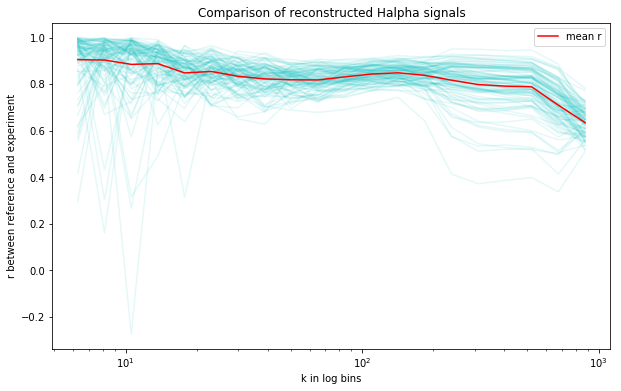

In [3]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(base_output_dir, names[0], names[1])
plot_all_r_vs_k(r_ha_list, results_dir, title="Comparison of reconstructed Halpha signals")

#### To identify the worst sample with the minimum r the following can work:
```
np.min(np.array(r_ha_list[1:]),axis=0) # Returns the r values for the sample with the lowest r
yolo = np.array(r_ha_list[1:]) # Store the array instead of list
min_index = np.unravel_index(np.argmin(yolo), yolo.shape) # returns the index, the first value of the tuple is the runXX
min_index
```

## Comparison of `test` and `xai_exp_oiii`
The following plot is the same as above but for OIII instead of Halpha. 

Saved plot ../output/xai_results//comparison_of_reconstructed_oiii_signals.png


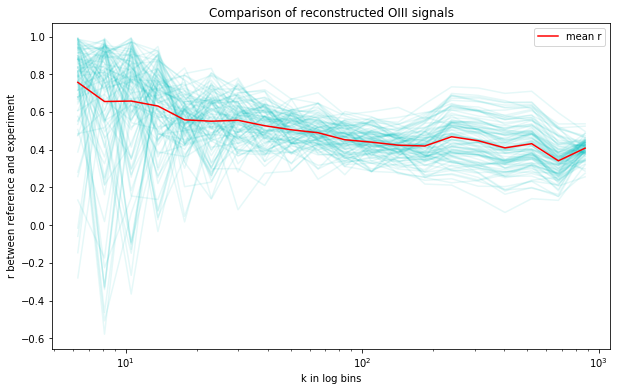

In [4]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(base_output_dir, names[0], names[2])
plot_all_r_vs_k(r_oiii_list, results_dir, title="Comparison of reconstructed OIII signals")

## Inspection of individual samples
It is also interesting to check single samples. The following plots maps of the "observed" and "true" singals such as the reconstructed ones followed by the correlation coefficient for this single sample compared to the true values. 

### First the reference `test` set inference
Here the user needs to specify the sample. 

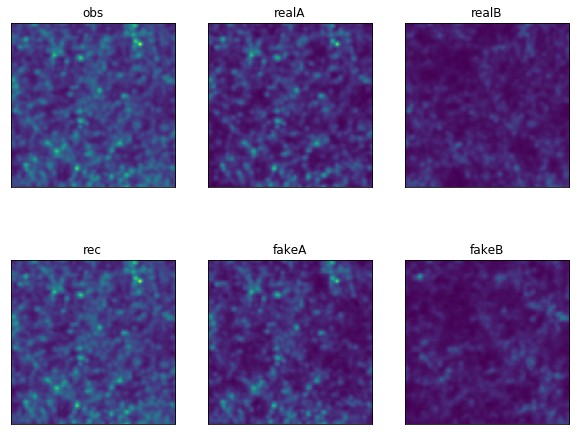

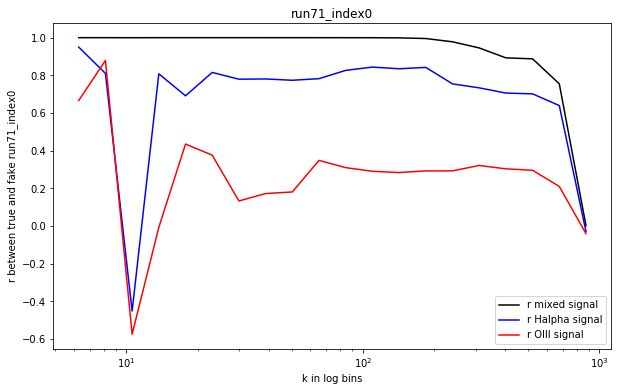

In [5]:
suffix=f"run71_index0"
data_ref = XAIDataLoader(base_output_dir, names[0], suffix=suffix)
plot_true_fake_maps(data_ref, results_dir, names[0], suffix=suffix)
plot_r_single_sample(data_ref, suffix, log_bins=True)

### Then the xai experiment `xai_exp_ha`  
In this experiment the "observed" map equals the "true A" map. The OIII signal is missing. So everything reconstructed as OIII is a mistake by the model.

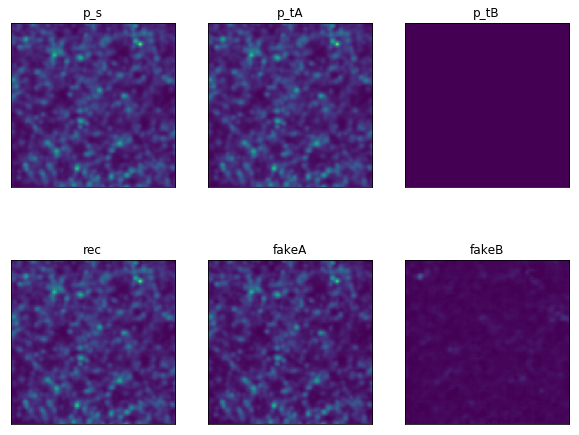

/home/scarlet/IM2IM/explain/correlation_coefficient.py:131: RuntimeWarning: invalid value encountered in true_divide
  return Px / np.sqrt( P1 * P2 ), k


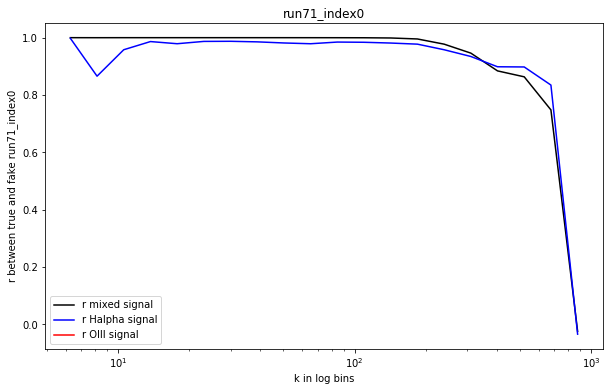

In [6]:
data_ha = XAIDataLoader(base_output_dir, names[1], suffix=suffix)
plot_true_fake_maps(data_ha, results_dir, names[1], suffix=suffix)
plot_r_single_sample(data_ha, suffix, log_bins=True)

### Then the xai experiment `xai_exp_oiii`  
In this experiment the "observed" map equals the "true B" map. The Halpha signal is missing. So everything reconstructed as Halpha is a mistake by the model.

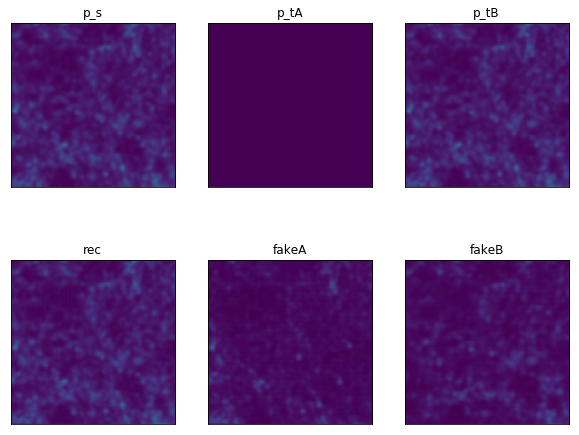

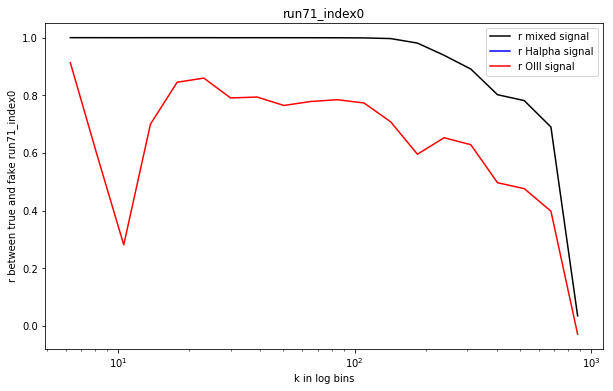

In [7]:
data_oiii = XAIDataLoader(base_output_dir, names[2], suffix=suffix)
plot_true_fake_maps(data_oiii, results_dir, names[2], suffix=suffix)
plot_r_single_sample(data_oiii, suffix, log_bins=True)

## Conclusion
**Our hypothesis** is that the GAN will "hallucinate" the other signal. It will produce two generated images with Halpha and OIII present, although the input image had only one signal available.

Indeed the GAN does generate the missing signal although it does not exist. Nevertheless, the effect is lower than expected. Comparing the correlation coefficients between the true and fake of all respective generated images, we see that the model only using one signal has a higher correlation to the true image than in the `test`. 
We can explain this as it is an easier task for the model to reconstruct if it does not have to distinguish between two signals. Moreover, this also points to that the model is able to distinguish the Halpha datadistribution from the OIII distribution. The question that not arises is what statistical property the model uses to achieve this.